## House Prices 

 - [Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
 - [學習](https://www.kaggle.com/code/shunsukeozeki/house-prices-regression-with-pytorch)
 - 我記得可以觀察資料和Col相關性
 - [tqdm](https://blog.csdn.net/qq_43391414/article/details/121981491)

In [26]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, Adam
from torch.nn import RMSNorm
from torch import nn
import torch
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import PowerTransformer, StandardScaler

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
train_data = pd.read_csv(r'D:\NCNU\深度學習實驗\w5\house-prices-advanced-regression-techniques\train.csv')
test_data = pd.read_csv(r'D:\NCNU\深度學習實驗\w5\house-prices-advanced-regression-techniques\test.csv')

In [29]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## Feature Engineering

 - 看缺失值
 - `display()`
     - IPython的內置函數，它用於在Jupyter Notebook環境中顯示Python 物件的圖形化表示或其他格式化輸出

In [30]:
pd.options.display.max_rows = 90
df_train_null = pd.DataFrame(train_data.isnull().sum(), columns=['Null Counts'])
df_test_null = pd.DataFrame(test_data.isnull().sum(), columns=['Null Counts'])
print('Training Data')
display(df_train_null[df_train_null['Null Counts'] != 0])
print('Test Data')
display(df_test_null[df_test_null['Null Counts'] != 0])

Training Data


,Null Counts
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


Test Data


,Null Counts
MSZoning,4
LotFrontage,227
Alley,1352
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,894
MasVnrArea,15
BsmtQual,44
BsmtCond,45


 - Correlation

In [31]:
pd.options.display.max_columns = 50
df_dtype = pd.DataFrame(train_data.dtypes, columns=['dtype'])
df_corr = train_data[df_dtype[df_dtype['dtype'] != 'object'].index].corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)
display(df_corr)
# 會顯示所有的
# df_corr = train_data[df_dtype[df_dtype['dtype'] != 'object'].index].corr().sort_values(by='SalePrice', ascending=False)
# display(df_corr.style.background_gradient(axis=None))

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


 - Feature engineering
     - [解說](https://www.kaggle.com/code/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda)

In [32]:
# Features used to modeling
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','KitchenQual','Neighborhood','MSZoning'
                ,'Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df_train_usefull = train_data[usefull_cols].copy()
df_test_usefull = test_data[usefull_cols].copy()

In [33]:
df_train_usefull.dtypes

OverallQual        int64
GrLivArea          int64
GarageArea         int64
TotalBsmtSF        int64
FullBath           int64
YearBuilt          int64
YearRemodAdd       int64
Fireplaces         int64
LotFrontage      float64
WoodDeckSF         int64
OpenPorchSF        int64
ExterQual         object
KitchenQual       object
Neighborhood      object
MSZoning          object
Alley             object
LotShape          object
LandContour       object
Condition1        object
HouseStyle        object
MasVnrType        object
SaleCondition     object
dtype: object

In [34]:
# Null Count
df_train_usefull_null = pd.DataFrame(df_train_usefull.isnull().sum(), columns=['Null'])
display(df_train_usefull_null[df_train_usefull_null != 0].dropna())

df_test_usefull_null = pd.DataFrame(df_test_usefull.isnull().sum(), columns=['Null'])
display(df_train_usefull_null[df_test_usefull_null != 0].dropna())

,Null
LotFrontage,259.0
Alley,1369.0
MasVnrType,872.0


,Null
GarageArea,0.0
TotalBsmtSF,0.0
LotFrontage,259.0
KitchenQual,0.0
MSZoning,0.0
Alley,1369.0
MasVnrType,872.0


In [35]:
# 填充
# 這邊注意是用 Training Data 去填充 Testing Data
df_test_usefull['GarageArea'] = df_test_usefull['GarageArea'].fillna(df_train_usefull['GarageArea'].mean())
df_test_usefull['TotalBsmtSF'] = df_test_usefull['TotalBsmtSF'].fillna(df_train_usefull['TotalBsmtSF'].mean())

# 其他的是補零
df_train_usefull['LotFrontage'] = df_train_usefull['LotFrontage'].fillna(0)
df_test_usefull['LotFrontage'] = df_test_usefull['LotFrontage'].fillna(0)
df_test_usefull['KitchenQual'] = df_test_usefull['KitchenQual'].fillna('TA')

In [36]:
# yeo-johnson
for col in ['GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF']:
    PT = PowerTransformer(method='yeo-johnson')
    PT.fit(df_train_usefull[[col]].values)
    df_train_usefull[col] = PT.transform(df_train_usefull[[col]].values)
    df_test_usefull[col] = PT.transform(df_test_usefull[[col]].values)

# Standard
for col in ['TotalBsmtSF','LotFrontage']:
    SC = StandardScaler().fit(df_train_usefull[[col]].values)
    df_train_usefull[col] = SC.transform(df_train_usefull[[col]].values)
    df_test_usefull[col] = SC.transform(df_test_usefull[[col]].values)

 - `YearBuilt`
     - Original construction date
 - `YearRemodAdd`
     - Remodel date

In [37]:
# Create YearRemodAdd -  YearBuilt flag columns
df_test_usefull['YearRemodAdd - YearBuilt'] = df_test_usefull['YearRemodAdd'] - df_test_usefull['YearBuilt']
df_train_usefull['YearRemodAdd - YearBuilt'] = df_train_usefull['YearRemodAdd'] - df_train_usefull['YearBuilt']

# Drop YearRemodAdd
df_train_usefull = df_train_usefull.drop(columns=['YearRemodAdd'])
df_test_usefull = df_test_usefull.drop(columns=['YearRemodAdd'])

 - `df_test_usefull['LotFrontage']`
     - Series(一維)
     - 適合做數值計算或對單一欄位操作
 - `df_test_usefull[['LotFrontage']]`
     - DataFrame(二維)
     - 適合後續當作表格處理，或一次選擇多個欄位

In [38]:
# One Hot
need_ont_hot = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']
df_train_usefull = pd.get_dummies(
    df_train_usefull,
    columns=need_ont_hot
)
df_test_usefull = pd.get_dummies(
    df_test_usefull,
    columns=need_ont_hot
)

 - `ExterQual` Evaluates the quality of the material on the exterior 
     - `Ex` Excellent
     - `Gd` Good
     - `TA` Average/Typical
     - `Fa` Fair
     - `Po` Poor
 - `KitchenQual` Kitchen quality
     - same as ExterQual

 - Downcasting behavior in `replace` is deprecated
     - 加上 `infer_objects(copy=False)` 來保留舊行為：
 - `.map`
     - 只影響單行，不影響整個DataFrame

In [39]:
# Ordinal vals
for col in ['ExterQual', 'KitchenQual']:
    df_train_usefull[col] = df_train_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)
    df_test_usefull[col] = df_test_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)


C:\Users\wendy\AppData\Local\Temp\ipykernel_24808\1047619113.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_usefull[col] = df_train_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)
C:\Users\wendy\AppData\Local\Temp\ipykernel_24808\1047619113.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_usefull[col] = df_test_usefull[col].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}).infer_objects(copy=False)


In [40]:
# 檢查
# print(df_train_usefull.select_dtypes(include=['object'])) # 看object
# print(df_train_usefull.isna().sum().sum())  # 總共多少 NaN
# print(df_train_usefull.applymap(type).nunique())  # 檢查每欄是否有不同型別 # 1 -> OK # 2 -> 有兩種type

# print(df_train_usefull.dtypes)  # 檢查 DataFrame 


In [41]:
# Transform DataFrame to ndarray
X_train = df_train_usefull.drop(columns='HouseStyle_2.5Fin').to_numpy().astype(np.float32)
y_train = train_data[['SalePrice']].to_numpy()
X_test = df_test_usefull.to_numpy().astype(np.float32)

# ndarray to Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

## Build Model

In [42]:
print(X_train.shape)
print(X_test.shape)

torch.Size([1460, 78])
torch.Size([1459, 78])


In [43]:
class Module(nn.Module):
    def __init__(self, input_dim): # input_dim 為輸入維度
        super(Module, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(16, 1)
        )
    def forward(self, X):
        return self.net(X)

In [44]:
# Hyper-parameter
epochs = 200
batch_size = 32

In [45]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1)

In [46]:
model = Module(X_train.shape[1]).to(device)
loss = nn.L1Loss()
optimizer = Adam(model.parameters(), weight_decay=1e-4)
history = {'rmse_loss':[]}
model_path = './model/'
lowest_rmse = 1e9

In [47]:
from torchsummary import summary
summary(model, (X_train.shape[-1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 48]           3,792
              ReLU-2                   [-1, 48]               0
           Dropout-3                   [-1, 48]               0
            Linear-4                   [-1, 32]           1,568
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                   [-1, 16]             528
              ReLU-8                   [-1, 16]               0
           Dropout-9                   [-1, 16]               0
           Linear-10                    [-1, 1]              17
Total params: 5,905
Trainable params: 5,905
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total

In [48]:
if not os.path.exists(model_path): os.mkdir(model_path)

for i in range(epochs):
    training_loss = 0
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        frame, label = data
        frame, label = frame.to(device), label.to(device)
        
        output = model(frame)
        output_loss = torch.sqrt(loss(output, label))
        training_loss += output_loss.item()
        
        # BP
        output_loss.backward()
        optimizer.step()
    history['rmse_loss'].append(training_loss / len(train_loader))
    print(f'Epoch\t{i + 1}\tRMSE: {training_loss / len(train_loader) : .4f}')
    
    # Store Model
    if training_loss / len(train_loader) < lowest_rmse:
        lowest_rmse = training_loss / len(train_loader)
        torch.save(model, os.path.join(model_path, 'model.pt'))
        print('\033[33mSave\033[0m')
    

Epoch	1	RMSE:  424.7390
Save
Epoch	2	RMSE:  423.0682
Save
Epoch	3	RMSE:  407.8726
Save
Epoch	4	RMSE:  335.6547
Save
Epoch	5	RMSE:  287.6932
Save
Epoch	6	RMSE:  285.8040
Save
Epoch	7	RMSE:  283.6817
Save
Epoch	8	RMSE:  279.6910
Save
Epoch	9	RMSE:  284.8377
Epoch	10	RMSE:  283.1630
Epoch	11	RMSE:  279.7361
Epoch	12	RMSE:  281.9191
Epoch	13	RMSE:  284.6983
Epoch	14	RMSE:  281.4074
Epoch	15	RMSE:  280.8560
Epoch	16	RMSE:  284.7923
Epoch	17	RMSE:  279.0084
Save
Epoch	18	RMSE:  282.0529
Epoch	19	RMSE:  279.1442
Epoch	20	RMSE:  276.8378
Save
Epoch	21	RMSE:  281.5497
Epoch	22	RMSE:  277.5874
Epoch	23	RMSE:  281.4824
Epoch	24	RMSE:  279.7646
Epoch	25	RMSE:  278.6206
Epoch	26	RMSE:  278.9629
Epoch	27	RMSE:  282.1588
Epoch	28	RMSE:  279.7037
Epoch	29	RMSE:  277.7672
Epoch	30	RMSE:  279.6563
Epoch	31	RMSE:  278.4268
Epoch	32	RMSE:  283.1566
Epoch	33	RMSE:  281.5381
Epoch	34	RMSE:  276.1354
Save
Epoch	35	RMSE:  278.2539
Epoch	36	RMSE:  278.2058
Epoch	37	RMSE:  277.6278
Epoch	38	RMSE:  275.8734
Save

RMSE Loss 243.3556969684103


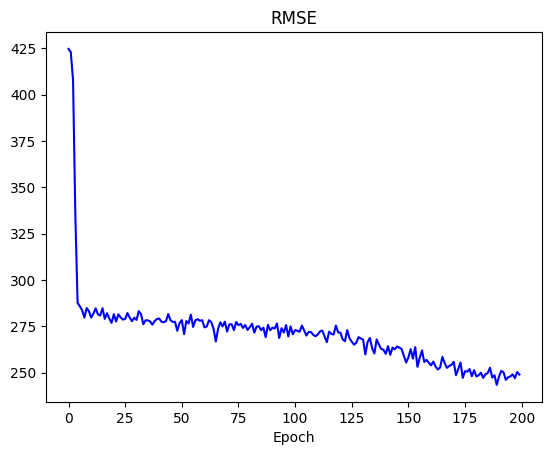

In [49]:
print('RMSE Loss', min(history['rmse_loss']))

plt.cla(); plt.clf()
plt.plot(history['rmse_loss'], 'b', label='RMSE')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.show()

In [50]:
for frame in df_train_usefull.columns:
    if frame not in df_test_usefull.columns: print(frame)

HouseStyle_2.5Fin


In [51]:
submit = 'Id,SalePrice\n'
idx = 1461
model = torch.load(os.path.join(model_path, 'model.pt'))
with torch.no_grad():
    model.eval()
    for data in test_loader:
        frame = data.to(device)
        output = model(frame)
        submit += f'{idx},{output.item()}\n'
        idx += 1

open('submit.csv', 'w').write(submit)
print('complete')

complete


C:\Users\wendy\AppData\Local\Temp\ipykernel_24808\3354521204.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(model_path, 'model.pt'))


In [52]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime(r'%Y_%m_%d__%H_%M_%S')
print(now)

2025_03_26__20_01_22
